In [1]:
%cd ..

/scratch/gpfs/zzada/fconv


In [77]:
import os
import pickle
import torch
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from scipy.stats import zscore, pearsonr
from util import subject
from util import plot
from collections import defaultdict
import seaborn as sns
from constants import *
from tqdm import tqdm
from util.path import Path
from himalaya.backend import set_backend

from himalaya.scoring import correlation_score
import sys
from importlib import reload

# resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e9

# confounds

In [34]:
dfc = pd.read_csv(
    "data/derivatives/fmriprep/sub-001/ses-1/func/sub-001_ses-1_task-Conv_run-1_desc-confounds_timeseries.tsv",
    sep="\t",
)
dfc

global_signal  global_signal_derivative1  \
0       627.307935                        NaN   
1       624.737483                  -2.570452   
2       624.008139                  -0.729344   
3       623.705264                  -0.302875   
4       624.831321                   1.126057   
..             ...                        ...   
539     595.343576                   1.908504   
540     596.031588                   0.688012   
541     596.701395                   0.669807   
542     596.321816                  -0.379579   
543     594.426792                  -1.895024   

     global_signal_derivative1_power2  global_signal_power2         csf  \
0                                 NaN         393515.245457  481.936383   
1                            6.607224         390296.922662  478.058828   
2                            0.531943         389386.157268  477.065866   
3                            0.091733         389008.256030  476.522812   
4                            1.268005         390414.179968  475.839324   
..                                ...                   ...         ...   
539                          3.642386         354433.973164  460.373519   
540                          0.473361         355253.653583  461.929946   
541                          0.448642         356052.554799  463.391648   
542                          0.144080         355599.708503  464.865998   
543                          3.591117         353343.211045  461.078281   

     csf_derivative1     csf_power2  csf_derivative1_power2  white_matter  \
0                NaN  232262.677415                     NaN    517.194972   
1          -3.877555  228540.242987               15.035434    516.754469   
2          -0.992962  227591.840162                0.985974    516.520381   
3          -0.543053  227073.990763                0.294907    516.132956   
4          -0.683488  226423.062575                0.467156    516.966243   
..               ...            ...                     ...           ...   
539         3.055788  211943.777413                9.337842    499.188587   
540         1.556427  213379.275190                2.422464    499.676327   
541         1.461701  214731.819125                2.136571    499.715087   
542         1.474351  216100.396409                2.173710    500.192620   
543        -3.787717  212593.181404               14.346801    500.091312   

     white_matter_derivative1  ...  motion_outlier71  motion_outlier72  \
0                         NaN  ...               0.0               0.0   
1                   -0.440503  ...               0.0               0.0   
2                   -0.234088  ...               0.0               0.0   
3                   -0.387425  ...               0.0               0.0   
4                    0.833287  ...               0.0               0.0   
..                        ...  ...               ...               ...   
539                  0.653042  ...               0.0               0.0   
540                  0.487740  ...               0.0               0.0   
541                  0.038760  ...               0.0               0.0   
542                  0.477533  ...               0.0               0.0   
543                 -0.101308  ...               0.0               0.0   

     motion_outlier73  motion_outlier74  motion_outlier75  motion_outlier76  \
0                 0.0               0.0               0.0               0.0   
1                 0.0               0.0               0.0               0.0   
2                 0.0               0.0               0.0               0.0   
3                 0.0               0.0               0.0               0.0   
4                 0.0               0.0               0.0               0.0   
..                ...               ...               ...               ...   
539               0.0               0.0               0.0               0.0   
540               0.0               0.0               0.0            

In [35]:
dfc[[c for c in dfc.columns if "derivative" in c]]

global_signal_derivative1  global_signal_derivative1_power2  \
0                          NaN                               NaN   
1                    -2.570452                          6.607224   
2                    -0.729344                          0.531943   
3                    -0.302875                          0.091733   
4                     1.126057                          1.268005   
..                         ...                               ...   
539                   1.908504                          3.642386   
540                   0.688012                          0.473361   
541                   0.669807                          0.448642   
542                  -0.379579                          0.144080   
543                  -1.895024                          3.591117   

     csf_derivative1  csf_derivative1_power2  white_matter_derivative1  \
0                NaN                     NaN                       NaN   
1          -3.877555               15.035434                 -0.440503   
2          -0.992962                0.985974                 -0.234088   
3          -0.543053                0.294907                 -0.387425   
4          -0.683488                0.467156                  0.833287   
..               ...                     ...                       ...   
539         3.055788                9.337842                  0.653042   
540         1.556427                2.422464                  0.487740   
541         1.461701                2.136571                  0.038760   
542         1.474351                2.173710                  0.477533   
543        -3.787717               14.346801                 -0.101308   

     white_matter_derivative1_power2  trans_x_derivative1  \
0                                NaN                  NaN   
1                           0.194043            -0.000658   
2                           0.054797            -0.000632   
3                           0.150098             0.007651   
4                           0.694367            -0.022792   
..                               ...                  ...   
539                         0.426464             0.007285   
540                         0.237891            -0.027113   
541                         0.001502            -0.015232   
542                         0.228038            -0.000577   
543                         0.010263            -0.001153   

     trans_x_derivative1_power2  trans_y_derivative1  \
0                           NaN                  NaN   
1                  4.332272e-07             0.016124   
2                  3.994240e-07            -0.043405   
3                  5.853933e-05             0.008397   
4                  5.194661e-04            -0.000046   
..                          ...                  ...   
539                5.306831e-05             0.005779   
540                7.351365e-04             0.060325   
541                2.320138e-04            -0.057304   
542                3.335062e-07             0.069671   
543                1.329640e-06            -0.136801   

     trans_y_derivative1_power2  trans_z_derivative1  \
0                           NaN                  NaN   
1                  2.599963e-04             0.039534   
2                  1.884029e-03             0.069097   
3                  7.050625e-05             0.024975   
4                  2.116000e-09            -0.011567   
..                          ...                  ...   
539                3.339684e-05            -0.099750   
540                3.639106e-03             0.081580   
541                3.283748e-03             0.132610   
542                4.854048e-03            -0.074900   
543                1.871449e-02             0.035760   

     trans_z_derivative1_power2  rot_x_derivative1  rot_x_derivative1_power2  \
0                           NaN                NaN                       NaN   
1                      0.001563           0.000823          

In [47]:
d = nib.load(
    "data/derivatives/fmriprep/sub-004/ses-1/func/sub-004_ses-1_task-Conv_run-1_space-fsaverage6_hemi-R_bold.func.gii"
)
d = d.agg_data()
d.shape, np.isnan(d).any(), np.isinf(d).any()

((40962, 544), False, False)

In [64]:
fsaverage_mask = d.sum(1) == 0

3486

# util.subject

In [22]:
reload(sys.modules["util.subject"])
from util import subject

In [ ]:
# data, conf = subject.get_bold(4, space="fsaverage6", confounds=[])
data = subject.get_bold(4, space="fsaverage6")
data.shape

In [23]:
presses, switches, df = subject.get_button_presses(5)
drt = df[(df.run == 1) & (df.trial == 1)]
drt

run  trial condition       role   comm.time
2     1    1.0         G    speaker    0.000014
3     1    1.0         G   listener   37.692316
4     1    1.0         G    speaker   65.867558
5     1    1.0         G   listener  103.606416
6     1    1.0         G    speaker  131.383190
7     1    1.0         G   listener  151.191446
8     1    1.0         G    speaker  169.365976
9     1    1.0         G   listener  178.958135
10    1    1.0         G  trial_end  180.021967

In [32]:
drt = df[(df.run == 5) & (df.trial == 2)]
drt

run  trial condition       role   comm.time
132    5    2.0         G   listener    0.000015
133    5    2.0         G    speaker   28.001663
134    5    2.0         G   listener   61.350148
135    5    2.0         G    speaker  101.399735
136    5    2.0         G   listener  144.348765
137    5    2.0         G    speaker  170.015526
138    5    2.0         G   listener  174.966326
139    5    2.0         G  trial_end  180.113570

<StemContainer object of 3 artists>

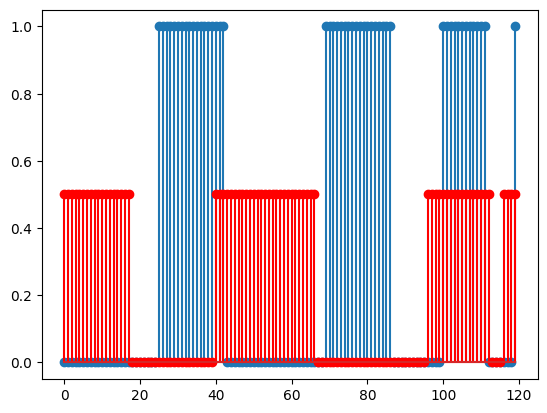

In [33]:
plt.stem(switches[:120])
plt.stem(switches[-240:-120] / 2, linefmt="r")

In [13]:
sub = 4
role = "listener" if sub > 100 else "speaker"
for _, group in df.groupby(["run", "trial"]):
    print(group)

    # switch onsets
    onsets = np.floor(group["comm.time"].values / 1.5).astype(int)
    trial_switches = np.zeros(120, dtype=int)
    s = 0 if group.iloc[0].role == "listener" else 1
    for i in range(len(onsets) - 1):
        trial_switches[onsets[i] : onsets[i + 1]] = (i + s) % 2
    if group.iloc[0].role == role:
        trial_switches = 1 - trial_switches

    break

    run  trial condition       role   comm.time
2     1    1.0         G    speaker    0.000014
3     1    1.0         G   listener   37.692316
4     1    1.0         G    speaker   65.867558
5     1    1.0         G   listener  103.606416
6     1    1.0         G    speaker  131.383190
7     1    1.0         G   listener  151.191446
8     1    1.0         G    speaker  169.365976
9     1    1.0         G   listener  178.958135
10    1    1.0         G  trial_end  180.021967
    run  trial condition       role   comm.time
28    1    4.0         G    speaker    0.000019
29    1    4.0         G   listener   31.245987
30    1    4.0         G    speaker   63.201081
31    1    4.0         G   listener   88.347378
32    1    4.0         G    speaker  113.150682
33    1    4.0         G   listener  145.613255
34    1    4.0         G    speaker  161.233451
35    1    4.0         G  trial_end  180.028139
    run  trial condition       role   comm.time
38    2    1.0         G   listener    0

In [1]:
onsets = (drt["comm.time"]).values.round().astype(int)

NameError: name 'drt' is not defined

In [96]:
df, pressesB, _ = subject.get_button_presses(105)

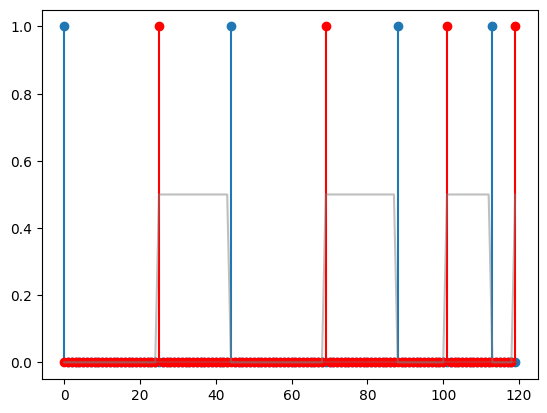

In [101]:
plt.stem(presses[:120])
plt.stem(pressesB[:120], linefmt="r-")
plt.plot(switches[:120] / 2, c="gray", alpha=0.5)

In [7]:
dfemb = subject.get_transcript(4, modelname="model-gpt2-medium_layer-0.75")

In [11]:
dfphone = subject.word_to_phones(dfemb)
dfphone

run  trial  word_idx  speaker  sentence        word    start      end  \
0       1      1         0        4         1         Um,    3.060    3.180   
1       1      1         1        4         1           I    3.460    3.560   
2       1      1         2        4         1       would    4.061    4.261   
3       1      1         3        4         1         not    4.301    4.461   
4       1      1         4        4         1        want    4.521    4.701   
...   ...    ...       ...      ...       ...         ...      ...      ...   
4834    5     19       490        4         2          it  176.524  176.597   
4835    5     19       491        4         2  definitely  176.645  177.224   
4836    5     19       492        4         2       plays  177.297  177.562   
4837    5     19       493        4         2           a  177.659  177.900   
4838    5     19       494        4         2       role.  178.141  178.431   

      score                                          embedding  
0     0.535  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1     0.974  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2     0.853  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3     0.845  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4     0.870  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
...     ...                                                ...  
4834  0.252  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4835  0.413  [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  
4836  0.735  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4837  0.576  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4838  0.539  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[4839 rows x 10 columns]

In [16]:
dfemb.trial.value_counts()

trial
18    715
11    689
7     654
19    653
10    651
4     608
16    600
6     586
13    583
1     512
Name: count, dtype: int64

In [15]:
dfphone.run.value_counts()

run
5    1001
3     993
4     966
2     950
1     929
Name: count, dtype: int64

In [12]:
dfphone.trial.value_counts()

trial
4     508
18    506
10    500
16    497
19    495
11    493
7     482
13    469
6     468
1     421
Name: count, dtype: int64

# fwdisp

In [4]:
modelname = "model-gpt2-medium_layer-0.75"

pklpath = Path(
    root="encoding",
    datatype=modelname,
    ext=".pkl",
)
files = glob(pklpath.starstr(["sub", "datatype"]))
len(files)

58

In [27]:
import gc

prod_enc_corrs, comp_enc_corrs = [], []
prod_scores, comp_scores = [], []
prod_disp, comp_disp = [], []

for filename in tqdm(files):
    sub = int(filename.split('/')[1][-3:])

    # correlation between BOLD and fwdisp
    data, fsdisp = subject.get_bold(sub, return_cofounds=["framewise_displacement"])
    _, switches = subject.get_button_presses(sub)
    prod_mask = switches.astype(bool)
    comp_mask = np.logical_not(prod_mask)

    prod_scores.append(correlation_score(data[prod_mask], fsdisp[prod_mask]))
    comp_scores.append(correlation_score(data[comp_mask], fsdisp[comp_mask]))
    prod_disp.append(fsdisp[prod_mask].mean())
    comp_disp.append(fsdisp[comp_mask].mean())

    # correlation between predicted BOLD and fwdisp
    with open(filename, "rb") as f:
        result = pickle.load(f)

        preds = np.stack(result["cv_preds"])
        preds = np.swapaxes(preds, 0, 1).reshape(5, 1200, -1)
        prod_enc_corrs.append(correlation_score(preds[-2, prod_mask], fsdisp[prod_mask]))
        comp_enc_corrs.append(correlation_score(preds[-1, comp_mask], fsdisp[comp_mask]))

    del result, preds
    gc.collect()

100%|██████████| 58/58 [28:37<00:00, 29.61s/it]


In [45]:
# np.savez('fwdisp.npz', prod_disp, comp_disp, prod_scores, comp_scores, prod_enc_corrs, comp_enc_corrs)

In [48]:
# fwres = np.load('fwdisp.npz')
fwres['arr_2'].mean(0).argmax() 

57842

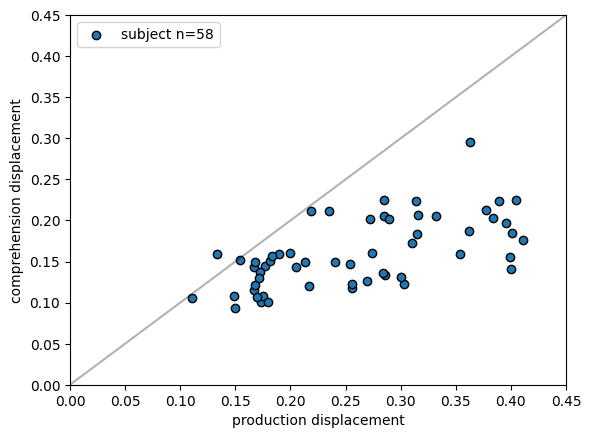

In [31]:
plt.scatter(prod_disp, comp_disp, label=f"subject n={len(prod_disp)}", edgecolors='black')
plt.axline(xy1=(0, 0), slope=1, alpha=0.3, color="k")
plt.xlim(0, 0.45)
plt.ylim(0, 0.45)
plt.xlabel("production displacement")
plt.ylabel("comprehension displacement")
plt.legend()
plt.show()

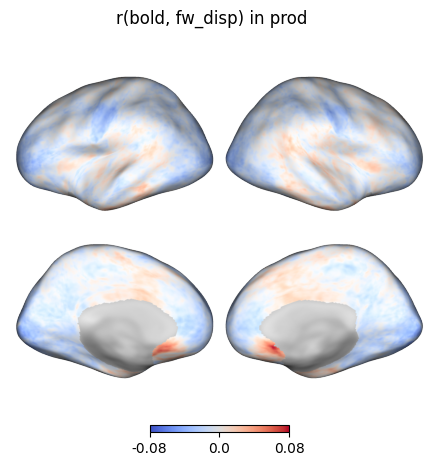

In [33]:
values = np.mean(prod_scores, axis=0)
mx = max(np.abs(values.min()), values.max())

# how correlated are voxels to FWdisplacement during production?
p = plot.get_surfplot()
p.add_layer(values, cmap="coolwarm", color_range=(-mx, mx))
fig = p.build()
fig.suptitle("r(bold, fw_disp) in prod")
fig.show()

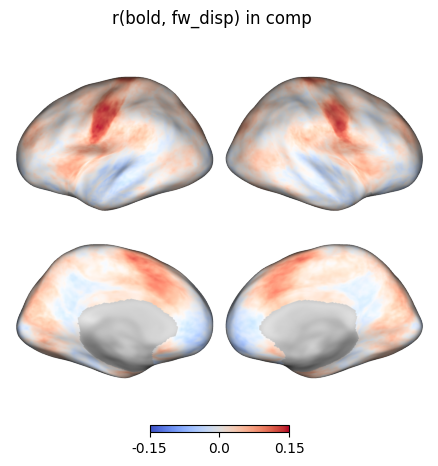

In [40]:
values = np.mean(comp_scores, axis=0)
mx = max(np.abs(values.min()), values.max())

# how correlated are voxels to FWdisplacement during production?
p = plot.get_surfplot()
p.add_layer(values, cmap="coolwarm", color_range=(-mx, mx))
fig = p.build()
fig.suptitle("r(bold, fw_disp) in comp")
fig.show()

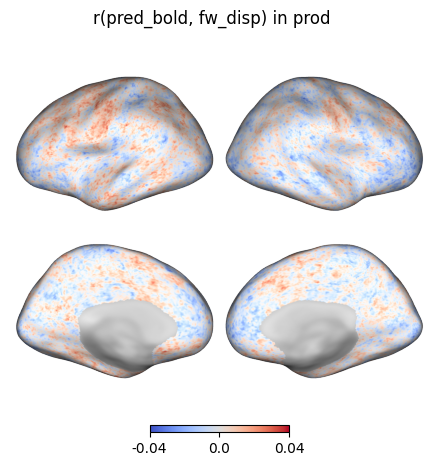

In [39]:
values = np.mean(prod_enc_corrs, axis=0)
mx = max(np.abs(values.min()), values.max())

# how correlated are voxels to FWdisplacement during production?
p = plot.get_surfplot()
p.add_layer(values, cmap="coolwarm", color_range=(-mx, mx))
fig = p.build()
fig.suptitle("r(pred_bold, fw_disp) in prod")
fig.show()

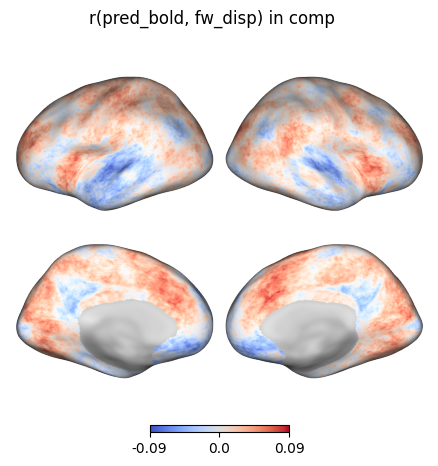

In [38]:
values = np.mean(comp_enc_corrs, axis=0)
mx = max(np.abs(values.min()), values.max())

# how correlated are voxels to FWdisplacement during production?
p = plot.get_surfplot()
p.add_layer(values, cmap="coolwarm", color_range=(-mx, mx))
fig = p.build()
fig.suptitle("r(pred_bold, fw_disp) in comp")
fig.show()

## explain disp

In [96]:
subs = list(CONVS_STRANGERS)+ [c - 100 for c in CONVS_STRANGERS]

confpath = Path(
    root="data/derivatives/fmriprep",
    datatype="func",
    sub="004",
    ses="1",
    task="Conv",
    run=1,
    desc="confounds",
    suffix="timeseries",
    ext=".tsv"
)


trials = [slice(14, 134), slice(148, 268), slice(282, 402), slice(416, 536)]

fcorrs = []
for sub in tqdm(subs):
    confpath.update(sub=f"{sub:03d}")
    dfs = []
    for run in RUNS:
        confpath.update(run=run)
        subdf = pd.read_csv(confpath, sep='\t', usecols=CONFOUNDS + ['framewise_displacement'])
        for trial in trials:
            dfs.append(subdf[trial])
    df = pd.concat(dfs).reset_index(drop=True)
    fcorrs.append(df.corr().loc['framewise_displacement'])

100%|██████████| 58/58 [00:12<00:00,  4.51it/s]


In [98]:
pd.concat(fcorrs, axis=1).mean(1).sort_values(ascending=False)

framewise_displacement        1.000000
trans_z_derivative1_power2    0.651485
rot_x_derivative1_power2      0.608328
trans_y_derivative1_power2    0.551957
rot_y_derivative1_power2      0.424717
trans_x_derivative1_power2    0.390743
rot_z_derivative1_power2      0.379847
rot_x_power2                  0.179505
trans_z_power2                0.166591
trans_y_power2                0.166470
rot_y_power2                  0.131324
rot_z_power2                  0.114931
trans_x_power2                0.112260
rot_x                         0.077947
a_comp_cor_01                 0.024860
rot_x_derivative1             0.019129
trans_x                       0.017247
cosine10                      0.015776
rot_z                         0.015429
cosine06                      0.014118
trans_y                       0.013746
trans_x_derivative1           0.010919
trans_z_derivative1           0.010352
a_comp_cor_00                 0.009846
cosine08                      0.007455
a_comp_cor_03            

In [87]:
df.corr().loc['framewise_displacement']

framewise_displacement        1.000000
a_comp_cor_00                 0.042440
a_comp_cor_01                 0.136639
a_comp_cor_02                -0.090014
a_comp_cor_03                 0.038754
a_comp_cor_04                -0.027025
cosine00                      0.019948
cosine01                     -0.023189
cosine02                     -0.029025
cosine03                     -0.063264
cosine04                      0.012730
cosine05                      0.014619
cosine06                      0.035516
cosine07                      0.084003
cosine08                      0.050005
cosine09                      0.057253
cosine10                     -0.021376
trans_x                      -0.000974
trans_x_derivative1          -0.102906
trans_x_power2                0.103067
trans_x_derivative1_power2    0.481401
trans_y                      -0.152956
trans_y_derivative1          -0.134411
trans_y_derivative1_power2    0.549992
trans_y_power2               -0.067409
trans_z                  

## i knew you were black

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [37]:
!ls data/derivatives/fmriprep/sub-004/ses-1/func/*task-Black*gii

data/derivatives/fmriprep/sub-004/ses-1/func/sub-004_ses-1_task-Black_run-1_space-fsaverage6_hemi-L_bold.func.gii
data/derivatives/fmriprep/sub-004/ses-1/func/sub-004_ses-1_task-Black_run-1_space-fsaverage6_hemi-R_bold.func.gii


In [49]:
subs = list(CONVS_STRANGERS)+ [c - 100 for c in CONVS_STRANGERS]
# these subjects didn't do listen to this story, not sure why
subs.remove(11)
subs.remove(111)
subs.remove(12)

In [66]:
corrs, disps = [], []
for sub in tqdm(subs):
    boldpath = Path(
        root="data/derivatives/fmriprep/",
        datatype='func',
        sub="004",
        ses=1,
        task='Black',
        run=1,
        space='fsaverage6',
        hemi='L',
        suffix='bold',
        ext=".func.gii",
    )
    boldpath.update(sub=f"{sub:03d}")

    paths = [boldpath, boldpath.copy().update(hemi='R')]

    confpath = Path(
        root="data/derivatives/fmriprep/",
        sub="004",
        ses=1,
        datatype='func',
        task='Black',
        run=1,
        desc='confounds',
        suffix='timeseries',
        ext=".tsv",
    )
    confpath.update(sub=f"{sub:03d}")

    confdata = pd.read_csv(confpath, sep='\t', usecols=CONFOUNDS)
    confdata.bfill(inplace=True)

    masker = subject.GiftiMasker(
        t_r=TR,
        ensure_finite=True,
        standardize='zscore_sample',
        standardize_confounds=True,
    )
    data = masker.fit_transform(paths, confounds=confdata.to_numpy())
    fdisp = pd.read_csv(confpath, sep='\t', usecols=['framewise_displacement']).fillna(value=0).to_numpy()

    corrs.append(correlation_score(data, fdisp))
    disps.append(fdisp)

  0%|          | 0/55 [00:00<?, ?it/s]/scratch/gpfs/zzada/fconv/code/util/subject.py:44: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  images.append(signal.clean(signals, **self.init_args))
  2%|▏         | 1/55 [00:05<05:11,  5.77s/it]/scratch/gpfs/zzada/fconv/code/util/subject.py:44: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  images.

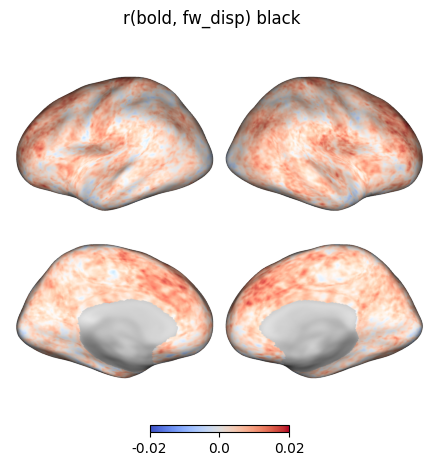

In [69]:
values = np.mean(corrs, axis=0)
mx = max(np.abs(values.min()), values.max())

# how correlated are voxels to FWdisplacement during production?
p = plot.get_surfplot()
p.add_layer(values, cmap="coolwarm", color_range=(-mx, mx))
fig = p.build()
fig.suptitle("r(bold, fw_disp) black")
fig.show()

/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

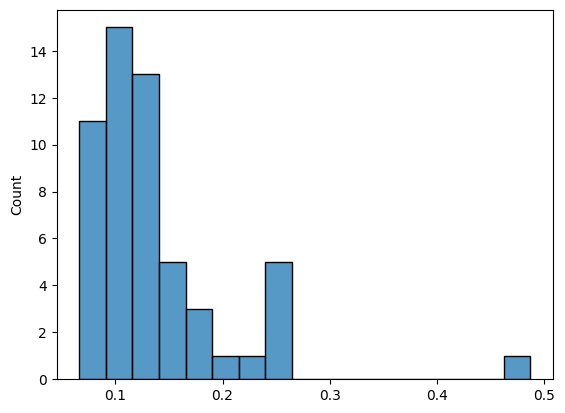

In [75]:
dd = np.stack(disps).mean((1,2))
sns.histplot(dd)

In [34]:
# disps = []
# for sub in subs:
#     confpath.update(sub=f"{sub:03d}")
#     if not confpath.isfile():
#         print(sub, 'no file')
#         continue
#     df = pd.read_csv(confpath, sep='\t', usecols=['framewise_displacement'])
#     disps.append(df.mean().item())

111 no file


11 no file
12 no file


# Encoding

In [86]:
reload(sys.modules["util.subject"])
reload(sys.modules["encoding"])
import encoding as enc

## regressors

In [57]:
sub = 105
X, features = enc.build_regressors(sub, modelname="model-gpt2-medium_layer-0.75")
X.shape, features

((1200, 2134),
 {'nuisance': slice(0, 4, None),
  'wp_rate': slice(4, 8, None),
  'phonemes': slice(8, 86, None),
  'production': slice(86, 1110, None),
  'comprehension': slice(1110, 2134, None)})

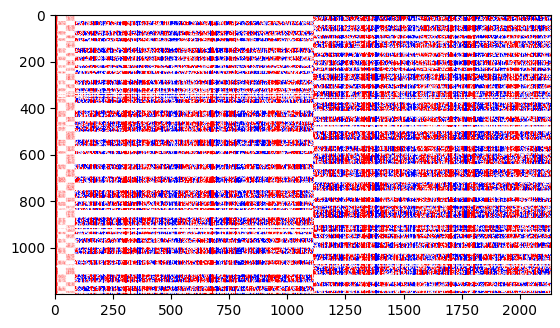

In [10]:
plt.imshow(X, vmin=-1, vmax=1, cmap="bwr")

In [58]:
data, conf = subject.get_bold(sub, return_cofounds=["framewise_displacement"])
data.shape

(1200, 81924)

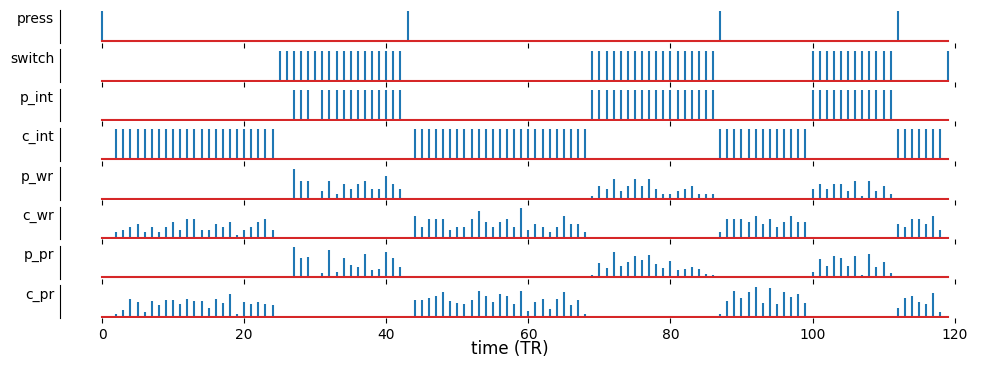

In [138]:
slc = slice(0, 120)
names = ["press", "switch", "p_int", "c_int", "p_wr", "c_wr", "p_pr", "c_pr"]
fig, axes = plt.subplots(8, 1, figsize=(12, 4), sharex=True)
for i, ax in enumerate(axes):
    ax.stem(X[slc, i], markerfmt="")
    # ax.plot(X[slc, i])
    ax.spines[["right", "top", "bottom"]].set_visible(False)
    ax.set_ylabel(names[i], rotation=0, horizontalalignment="right")
    ax.get_yaxis().set_ticks([])
    ax.spines[["right", "top", "bottom"]].set_visible(False)
fig.supxlabel("time (TR)")
fig.show()

In [52]:
def build_epochs(values: np.ndarray, onsets: np.ndarray, tmin: int = 5, tmax: int = 5) -> np.ndarray:
    epochs = []
    for onset in onsets:
        start, end = onset - tmin, onset + tmax
        if start > 0 and end < conf.size:
            epochs.append(conf[start:end])
    return np.stack(epochs).squeeze()

In [93]:
epochs = []
for sub in tqdm(SUBS_STRANGERS):
    X, _ = enc.build_regressors(sub, modelname="model-gpt2-medium_layer-0.75")
    _, conf = subject.get_bold(sub, return_cofounds=["framewise_displacement"])
    # events, label = X[:, 0].nonzero()[0], 'button press'
    # events, label = (np.diff(X[:, 1]) > 0).nonzero()[0], 'comp -> prod'
    events, label = (np.diff(X[:, 1]) < 0).nonzero()[0], 'prod -> comp'
    epochs.append(build_epochs(conf, events))
epochs = np.vstack(epochs)
epochs.shape

100%|██████████| 58/58 [02:55<00:00,  3.02s/it]


(1448, 10)

In [65]:
tmin, tmax = 5, 5
# events, label = X[:, 0].nonzero()[0], 'button press'
events, label = (np.diff(X[:, 1]) > 0).nonzero()[0], 'comp -> prod'
# events, label = (np.diff(X[:, 1]) < 0).nonzero()[0], 'prod -> comp'
epochs = build_epochs(conf, events)
epochs.shape

(33, 10)

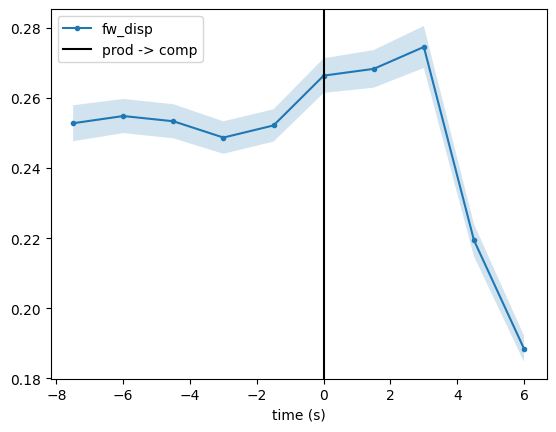

In [94]:
xaxis = np.arange(-tmin, tmax) * TR
mean = np.mean(epochs, 0).squeeze()
err = np.std(epochs, 0).squeeze() / np.sqrt(epochs.shape[0])
plt.plot(xaxis, mean, label='fw_disp', marker='.')
plt.fill_between(xaxis, mean-err, mean+err, alpha=.2)
plt.axvline(0, c='k', label=label)
plt.xlabel('time (s)')
plt.legend(loc='best')
plt.show()

In [200]:
# prod_roi_mask.shape
data[c_mask][:, prod_roi_mask].shape

(541, 6619)

In [201]:
c_mask = X[:, 1] == 0
c_vox = correlation_score(data[c_mask][:, prod_roi_mask], conf[c_mask]).argmax()
c_vox

2857

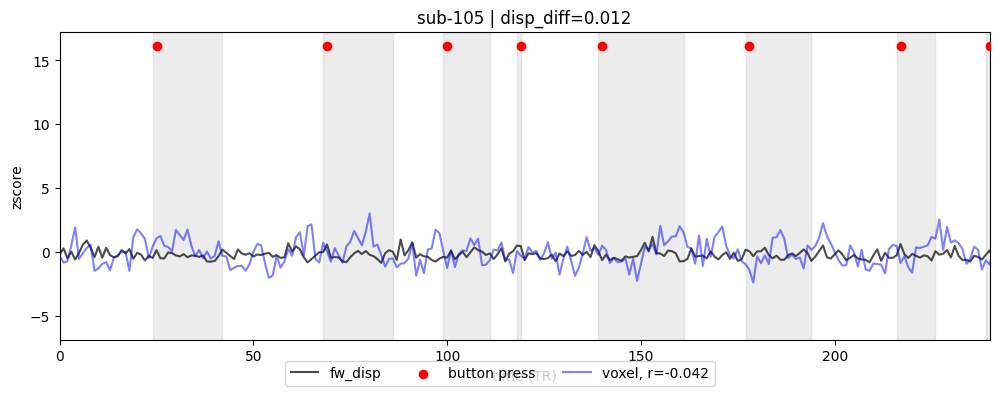

In [202]:
fig, ax = plt.subplots(figsize=(12, 4))

switches = [0] + np.nonzero(np.diff(X[:, 1]))[0].tolist()
for i in range(1, len(switches)):
    if i % 2 == 0:
        ax.axvspan(switches[i-1], switches[i], color='gray', alpha=0.15, zorder=1)

ax.plot(zscore(conf), c='k', label='fw_disp', alpha=0.7, zorder=2)

presses = X[:, 0].nonzero()[0]
ax.scatter(presses, np.ones_like(presses) * ax.get_ylim()[1], c='red', label='button press', zorder=3)

r = pearsonr(data[:, c_vox], conf.squeeze()).statistic
ax.plot(zscore(data[:, c_vox]), c='blue',  zorder=4, alpha=0.5, label=f'voxel, r={r:.3f}')
# ax.plot(zscore(data[:, p_vox]), c='green', zorder=4,  alpha=0.5)
ax.set_xlim(0, 240)
# ax.set_xlim(960, 1200)

compd = conf[X[:, 0] == 0].mean()
prodd = conf[X[:, 0] == 1].mean()
ax.set(ylabel='zscore', xlabel='time (TR)', title=f'sub-{sub:03d} | disp_diff={compd-prodd:.3f}')

fig.legend(loc="lower center", ncol = 3, alignment='left')
fig.show()

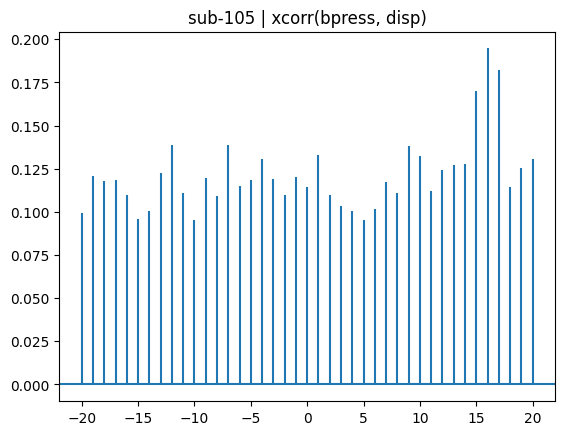

In [147]:
plt.title(f'sub-{sub:03d} | xcorr(bpress, disp)')
plt.xcorr(X[:, 0], conf.squeeze(), maxlags=20)
plt.show()

In [15]:
with open(
    f"encoding/sub-{sub:03d}/model-gpt2-medium_layer-0.75/sub-{sub:03d}.pkl", "rb"
) as f:
    ds = pickle.load(f)
ds.keys()

dict_keys(['cv_scores', 'cv_scores_prod', 'cv_scores_comp', 'cv_alphas', 'cv_preds', 'in_prod', 'in_comp', 'cv_models'])

In [16]:
preds = np.stack(ds["cv_preds"])
preds = np.swapaxes(preds, 0, 1).reshape(5, 1200, -1)
preds.shape

(5, 1200, 81924)

In [17]:
scores = np.stack(ds["cv_scores"]).mean(0)
print(scores.shape)
print(scores.max(-1))
print(scores.argmax(-1))

(5, 81924)
[0.34522906 0.2472285  0.13502821 0.3223776  0.36159092]
[ 5544 34602 38227 77042 66705]


In [21]:
voxid = 212
voxid = 66705

for score, feature in zip(scores[:, voxid].round(4), features):
    print(feature, score)

nuisance 0.0134
wp_rate 1e-04
phonemes 0.0023
production -0.0294
comprehension 0.3616


In [22]:
fnames = list(features.keys())
features

{'nuisance': slice(0, 4, None),
 'wp_rate': slice(4, 8, None),
 'phonemes': slice(8, 86, None),
 'production': slice(86, 1110, None),
 'comprehension': slice(1110, 2134, None)}

nuisance
wp_rate
phonemes
production
comprehension


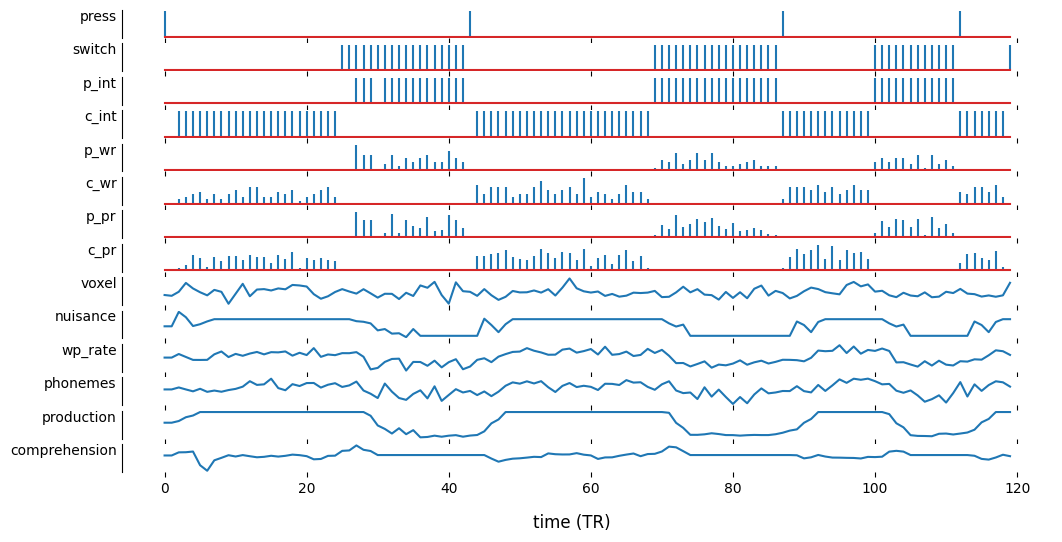

In [23]:
slc = slice(0, 120)

names = ["press", "switch", "p_int", "c_int", "p_wr", "c_wr", "p_pr", "c_pr"]
fig, axes = plt.subplots(14, 1, figsize=(12, 6), sharex=True)
for i, ax in enumerate(axes):
    ax.stem(X[slc, i], markerfmt="")
    ax.set_ylabel(names[i], rotation=0, horizontalalignment="right")
    if i == len(names) - 1:
        break

# plot actuals
i += 1
axes[i].plot(data[slc, voxid])
axes[i].set_ylabel("voxel", rotation=0, horizontalalignment="right")

# plot predictions
i += 1
for j in range(len(fnames)):
    axes[i + j].plot(preds[j, slc, voxid])
    axes[i + j].set_ylabel(fnames[j], rotation=0, horizontalalignment="right")
    print(fnames[j])

for ax in axes:
    ax.get_yaxis().set_ticks([])
    ax.spines[["right", "top", "bottom"]].set_visible(False)

fig.supxlabel("time (TR)")
fig.show()

In [24]:
print(pearsonr(data[:, voxid], conf[:, 0]))
for i in range(len(fnames)):
    print(fnames[i], pearsonr(preds[i, :, voxid], conf[:, 0]))

PearsonRResult(statistic=0.03832875652260853, pvalue=0.1845580089315461)
nuisance PearsonRResult(statistic=-0.04638223433142109, pvalue=0.10829202445347391)
wp_rate PearsonRResult(statistic=0.014819012680032294, pvalue=0.6080640687289771)
phonemes PearsonRResult(statistic=-0.022266446655133682, pvalue=0.4409298195192763)
production PearsonRResult(statistic=-0.026646696618731956, pvalue=0.3563875413131502)
comprehension PearsonRResult(statistic=-0.0317007889548526, pvalue=0.27251950706182226)


In [25]:
in_prod = ds["in_prod"]
in_comp = ds["in_comp"]

In [26]:
print("brain prod", pearsonr(data[in_prod, voxid], conf[in_prod, 0]).statistic)
print("brain comp", pearsonr(data[in_comp, voxid], conf[in_comp, 0]).statistic)
for i in range(len(fnames)):
    print(
        fnames[i],
        "prod",
        pearsonr(preds[i, in_prod, voxid], conf[in_prod, 0]).statistic,
    )
    print(
        fnames[i],
        "comp",
        pearsonr(preds[i, in_comp, voxid], conf[in_comp, 0]).statistic,
    )

brain prod -0.1519735479556865
brain comp 0.08151688241588999
nuisance prod -0.12887125740460856
nuisance comp -0.04405920408354318
wp_rate prod -0.1807661330389368
wp_rate comp 0.09121537042188309
phonemes prod -0.015994738573722325
phonemes comp 0.023811248454955965
production prod -0.16658235630362866
production comp -0.028097373687663466
comprehension prod -0.008090506558533715
comprehension comp -0.010644344053287184


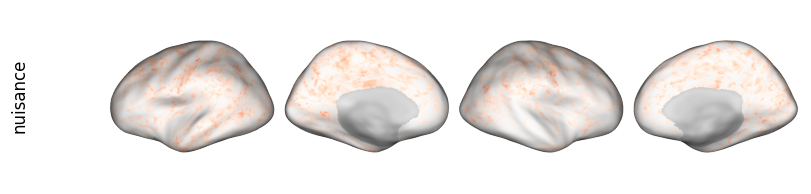

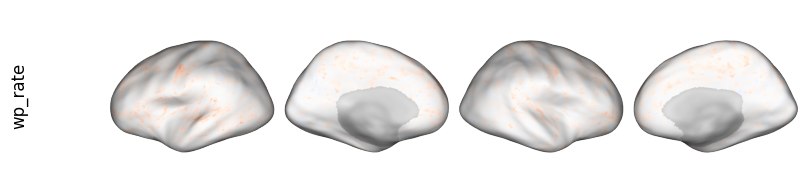

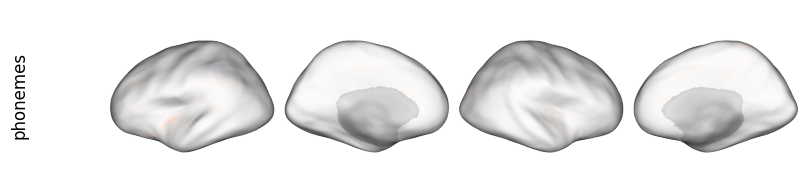

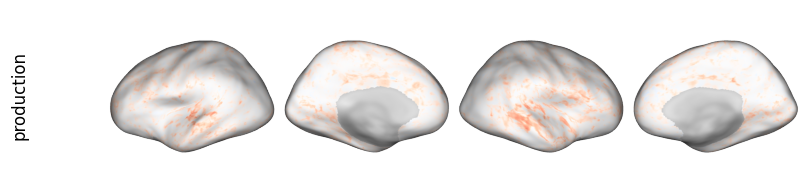

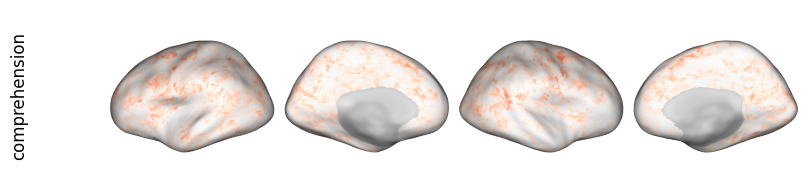

In [27]:
for i, feature in enumerate(fnames):
    values = scores[i]
    p = plot.get_surfplot(size=(800, 200), zoom=1.2, layout="row")
    p.add_layer(values, cmap="coolwarm", color_range=(-0.5, 0.5), cbar=False)
    fig = p.build()
    fig.supylabel(feature)
    fig.show()

## model

In [44]:
feature_names = list(features.keys())
slices = list(features.values())

In [47]:
pipeline = enc.build_model(feature_names, slices, np.linspace(0, 1, 10), 0, 1)
pipeline

Pipeline(steps=[('columnkernelizer',
                 ColumnKernelizer(n_jobs=1,
                                  transformers=[('nuissance',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler(with_std=False)),
                                                                 ('delayer',
                                                                  Delayer(delays=[2,
                                                                                  3,
                                                                                  4,
                                                                                  5])),
                                                                 ('kernelizer',
                                                                  Kernelizer())]),
                                                 slice(0, 3, None)),
                                                ('producton',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler(with_std=False)),
                                                                 ('delayer',
                                                                  Delayer(delays=[2,
                                                                                  3,...
                                                                  StandardScaler(with_std=False)),
                                                                 ('delayer',
                                                                  Delayer(delays=[2,
                                                                                  3,
                                                                                  4,
                                                                                  5])),
                                                                 ('kernelizer',
                                                                  Kernelizer())]),
                                                 slice(1027, 2051, None))])),
                ('caster', Caster()),
                ('multiplekernelridgecv',
                 MultipleKernelRidgeCV(kernels='precomputed',
                                       solver_params={'alphas': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                                      'progress_bar': 0}))])

# intersubject

In [87]:
import pickle
import numpy as np
from util import subject
from util.path import Path
from himalaya.scoring import correlation_score, correlation_score_split
from sklearn.model_selection import PredefinedSplit
from constants import CONV_TRS, RUNS, CONVS_STRANGERS

import matplotlib.pyplot as plt
from tqdm import tqdm
from surfplot import Plot
from surfplot.utils import threshold
from neuromaps.datasets import fetch_fsaverage

In [52]:
surfaces = fetch_fsaverage(data_dir="mats", density="41k")
lh, rh = surfaces["inflated"]
sulc_lh, sulc_rh = surfaces["sulc"]

In [61]:
from seaborn import color_palette

cmap = color_palette("coolwarm", as_cmap=True)

In [6]:
modelname = "model-gpt2-medium_layer-0.75"

In [86]:
subjects = np.concatenate((np.array(CONVS_STRANGERS) - 100, CONVS_STRANGERS))

In [90]:
scores = []
scores_prod = []
scores_comp = []

run_ids = np.repeat(RUNS, CONV_TRS * 2)
kfold = PredefinedSplit(run_ids)

for subA in tqdm(subjects):
    # load subA brain data and subB model
    # use subB prod model with subA embeddings for comprehension
    subB = subject.get_partner(subA)
    dataA = subject.get_bold(subA)

    # load encoding model
    encpath = Path(root="encoding", sub=f"{subB:03d}", datatype=modelname, ext=".pkl")
    with open(encpath, "rb") as f:
        ds = pickle.load(f)
        del ds["cv_models"]

    for k, (_, test_index) in enumerate(kfold.split()):
        Y_test = dataA[test_index]
        Y_preds = ds["cv_preds"][k]

        prod_mask = ds["in_prod"][test_index]
        comp_mask = ds["in_comp"][test_index]

        scores_prod.append(correlation_score(Y_test[prod_mask], Y_preds[1, prod_mask]))
        scores_comp.append(correlation_score(Y_test[comp_mask], Y_preds[2, comp_mask]))
        scores.append(correlation_score_split(Y_test, Y_preds))

scores = np.stack(scores).mean(0)
scores_prod = np.stack(scores_prod).mean(0)
scores_comp = np.stack(scores_comp).mean(0)
scores.shape, scores.max(1)

100%|██████████| 58/58 [27:57<00:00, 28.92s/it]


((3, 81924), array([0.04264869, 0.04455756, 0.08567119], dtype=float32))

In [107]:
np.savez("vxv-mbc.npz", scores=scores, scores_prod=scores_prod, scores_comp=scores_comp)

In [102]:
scores_prod.min(), scores_prod.max(), scores_comp.min(), scores_comp.max()

(-0.1813562, 0.12356323, -0.14582048, 0.15066877)

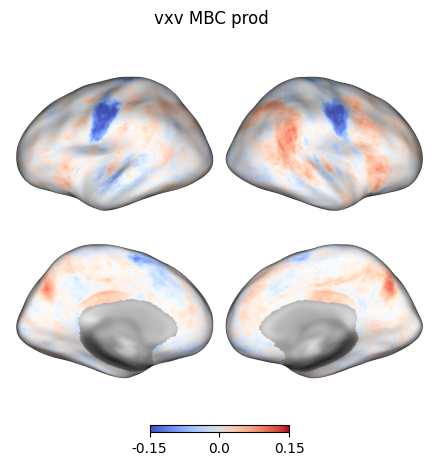

In [106]:
p = Plot(surf_lh=lh, surf_rh=rh, brightness=0.7)
p.add_layer({"left": sulc_lh, "right": sulc_rh}, cmap="binary_r", cbar=False)
p.add_layer(scores_prod, cmap=cmap, color_range=(-0.15, 0.15))
# p.add_layer(np.abs(scores_prod), cmap='magma', color_range=(-0, .15))
fig = p.build()
fig.suptitle("vxv MBC prod")
fig.show()

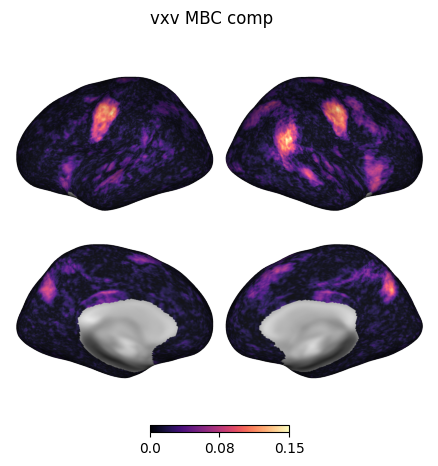

In [104]:
p = Plot(surf_lh=lh, surf_rh=rh, brightness=0.7)
p.add_layer({"left": sulc_lh, "right": sulc_rh}, cmap="binary_r", cbar=False)
# p.add_layer(scores_comp, cmap=cmap, color_range=(-.15, .15))
p.add_layer(np.abs(scores_comp), cmap="magma", color_range=(-0, 0.15))
fig = p.build()
fig.suptitle("vxv MBC comp")
fig.show()

In [ ]:
p = Plot(surf_lh=lh, surf_rh=rh, brightness=0.7)
p.add_layer({"left": sulc_lh, "right": sulc_rh}, cmap="binary_r", cbar=False)
p.add_layer(np.abs(scores_prod), cmap=cmap, color_range=(0, 0.4))
fig = p.build()
# fig.suptitle('vxv ISC')
fig.show()

# ISC

In [13]:
# 10 min per lag
scores = defaultdict(list)
for conv in tqdm(CONVS_STRANGERS):
    subA = subject.get_partner(conv)
    subB = conv
    dataA = subject.get_bold(subA)
    dataB = subject.get_bold(subB)
    for i in [-5, 5]:
        if i == 0:
            score = correlation_score(dataA, dataB)
        elif i < 0:
            score = correlation_score(dataA[:i], dataB[-i:])
        elif i > 0:
            score = correlation_score(dataA[i:], dataB[:-i])

        scores[i].append(score)
    # break

100%|██████████| 29/29 [26:02<00:00, 53.89s/it]


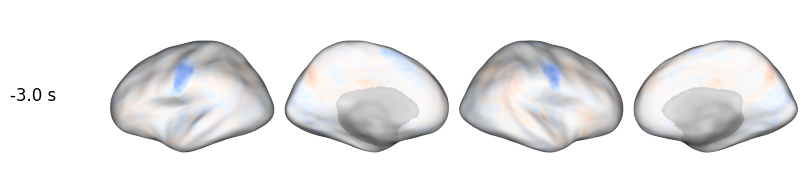

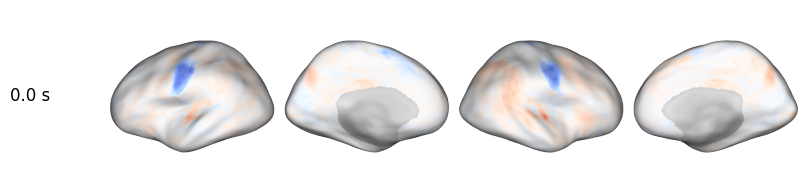

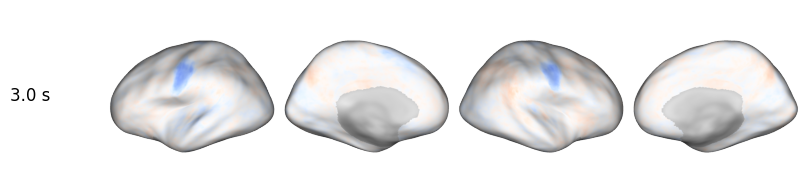

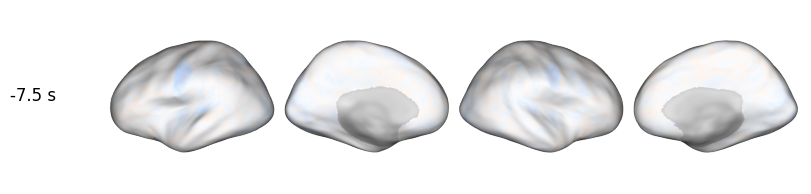

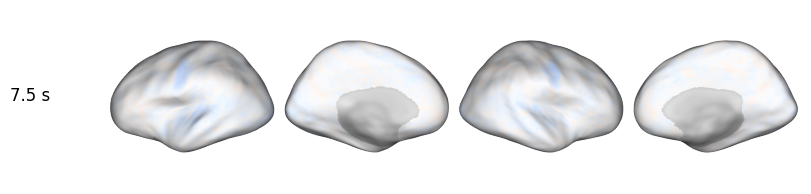

In [14]:
for lag in scores.keys():
    p = plot.get_surfplot(layout="row", size=(800, 200), zoom=1.2)
    p.add_layer(np.mean(scores[lag], axis=0), cmap="coolwarm", cbar=False, color_range=(-.2, .2))
    fig = p.build()
    fig.supylabel(f'{lag * TR} s', rotation=0)
    fig.show()

# Parcellation

In [150]:
from util.atlas import get_glasser

In [151]:
parc_mask, id2label = get_glasser()

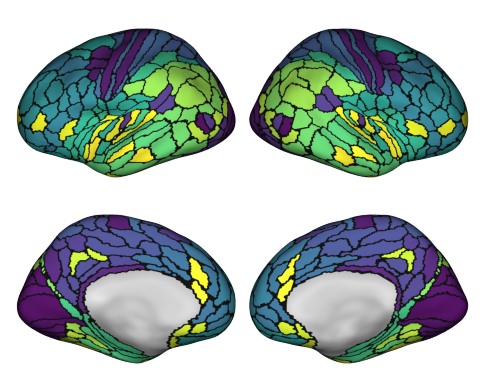

In [152]:
p = plot.get_surfplot()
p.add_layer(parc_mask, cbar=False)
p.add_layer(parc_mask, cmap="gray", as_outline=True, cbar=False)
fig = p.build()
fig.show()

In [13]:
id2label.values()

dict_values(['???', 'L_V1_ROI', 'L_MST_ROI', 'L_V6_ROI', 'L_V2_ROI', 'L_V3_ROI', 'L_V4_ROI', 'L_V8_ROI', 'L_4_ROI', 'L_3b_ROI', 'L_FEF_ROI', 'L_PEF_ROI', 'L_55b_ROI', 'L_V3A_ROI', 'L_RSC_ROI', 'L_POS2_ROI', 'L_V7_ROI', 'L_IPS1_ROI', 'L_FFC_ROI', 'L_V3B_ROI', 'L_LO1_ROI', 'L_LO2_ROI', 'L_PIT_ROI', 'L_MT_ROI', 'L_A1_ROI', 'L_PSL_ROI', 'L_SFL_ROI', 'L_PCV_ROI', 'L_STV_ROI', 'L_7Pm_ROI', 'L_7m_ROI', 'L_POS1_ROI', 'L_23d_ROI', 'L_v23ab_ROI', 'L_d23ab_ROI', 'L_31pv_ROI', 'L_5m_ROI', 'L_5mv_ROI', 'L_23c_ROI', 'L_5L_ROI', 'L_24dd_ROI', 'L_24dv_ROI', 'L_7AL_ROI', 'L_SCEF_ROI', 'L_6ma_ROI', 'L_7Am_ROI', 'L_7PL_ROI', 'L_7PC_ROI', 'L_LIPv_ROI', 'L_VIP_ROI', 'L_MIP_ROI', 'L_1_ROI', 'L_2_ROI', 'L_3a_ROI', 'L_6d_ROI', 'L_6mp_ROI', 'L_6v_ROI', 'L_p24pr_ROI', 'L_33pr_ROI', 'L_a24pr_ROI', 'L_p32pr_ROI', 'L_a24_ROI', 'L_d32_ROI', 'L_8BM_ROI', 'L_p32_ROI', 'L_10r_ROI', 'L_47m_ROI', 'L_8Av_ROI', 'L_8Ad_ROI', 'L_9m_ROI', 'L_8BL_ROI', 'L_9p_ROI', 'L_10d_ROI', 'L_8C_ROI', 'L_44_ROI', 'L_45_ROI', 'L_47l_ROI', 

In [186]:
region_numbers = [51, 53, 9, 8, 54, 56, 78]
for i in region_numbers:
    print(id2label[i])
regions = np.where(np.isin(parc_mask, region_numbers), parc_mask, 0)
regions.shape, regions.sum()

L_1_ROI
L_3a_ROI
L_3b_ROI
L_4_ROI
L_6d_ROI
L_6v_ROI
L_6r_ROI


((81924,), 217376)

In [191]:
prod_roi_mask = regions != 0

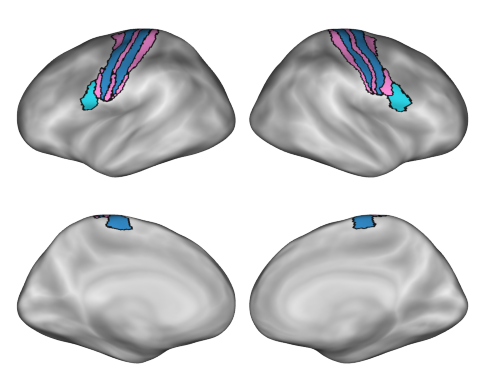

In [187]:
p = plot.get_surfplot()
p.add_layer(regions, cmap="tab10", cbar=False)
p.add_layer(regions, cmap="gray", as_outline=True, cbar=False)
fig = p.build()

In [163]:
del id2label[0]

In [180]:
label2id = {l:i for i,l in id2label.items()}

In [185]:
rois = ['1', '3a', '3b', '4', '6d', '6v', '6r']
for roi in rois:
    print(roi, label2id[f'L_{roi}_ROI'])

1 51
3a 53
3b 9
4 8
6d 54
6v 56
6r 78


In [174]:
!mkdir -p figures/glasser-rois

In [ ]:
for i, label in id2label.items():
    regions = parc_mask == i
    p = plot.get_surfplot(size=(800, 200), zoom=1.2, layout='row')
    p.add_layer(regions, cmap="tab10", cbar=False)
    p.add_layer(regions, cmap="gray", as_outline=True, cbar=False)
    fig = p.build()
    fig.supylabel(f'{i}:{label}', rotation=0)
    fig.savefig(f'figures/glasser-rois/{i:03d}-{label}.png')
    fig.close()
plt.close()

# 'story' encoding

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
subs = list(CONVS_STRANGERS)+ [c - 100 for c in CONVS_STRANGERS]
# these subjects didn't do listen to this story, not sure why
subs.remove(11)
subs.remove(111)
subs.remove(12)

In [4]:
import torch
from sklearn.preprocessing import StandardScaler
from voxelwise_tutorials.delayer import Delayer
from sklearn.model_selection import KFold
from himalaya.kernel_ridge import KernelRidgeCV
from sklearn.pipeline import make_pipeline
from himalaya.scoring import correlation_score
from himalaya.backend import set_backend

In [5]:
# Function to average embeddings per TR
def construct_predictors(transcript_df, n_features, stim_dur, tr=1.5):

    # Find total number of TRs
    stim_trs = np.ceil(stim_dur / tr)

    # Add column to transcript with TR indices
    transcript_df['TR'] = transcript_df.onset.divide(tr).apply(np.floor).apply(int)
    
    # Compile the words within each TR
    words_per_tr = transcript_df.groupby('TR')['word'].apply(list)
    
    # Average the embeddings within each TR
    embeddings_per_tr = transcript_df.groupby('TR')['embedding'].mean()
    
    # Loop through TRs
    words_trs = []
    embeddings_trs = []
    for t in np.arange(stim_trs):
        if t in words_per_tr:
            words_trs.append(words_per_tr[t])
    
            # Fill in empty TRs with zero vectors
            if embeddings_per_tr[t] is not np.nan:
                embeddings_trs.append(embeddings_per_tr[t])
            else:
                embeddings_trs.append(np.zeros(n_features))
        else:
            words_trs.append([])
            embeddings_trs.append(np.zeros(n_features))
    
    embeddings = np.vstack(embeddings_trs)
    return embeddings

In [8]:
# Reload transcript with embeddings if already generated
transcript_f = 'black_gpt2.pkl'
with open(transcript_f, 'rb') as f:
    transcript_gpt2 = pickle.load(f)

In [9]:
# GPT-2 embeddings are 768-dimensional
X = construct_predictors(transcript_gpt2, 768, 800, tr=1.5)
X.shape

(534, 768)

In [10]:
# Split-half outer and inner cross-validation
outer_cv = KFold(n_splits=2)
inner_cv = KFold(n_splits=5)

# Mean-center each feature (columns of predictor matrix)
scaler = StandardScaler(with_mean=True, with_std=True)

# Create delays at 3, 4.5, 6, 7.5 seconds (1.5 s TR)
delayer = Delayer(delays=[2, 3, 4, 5])

# Ridge regression with alpha grid and nested CV
alphas = np.logspace(1, 10, 10)
ridge = KernelRidgeCV(alphas=alphas, cv=inner_cv)

# Chain transfroms and estimator into pipeline
pipeline = make_pipeline(scaler, delayer, ridge)

In [11]:
set_backend('torch')

<module 'himalaya.backend.torch' from '/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/himalaya/backend/torch.py'>

In [12]:
start_trs = 8
end_trs = 8
results = []

for sub in tqdm(subs):
    boldpath = Path( root="data/derivatives/fmriprep/", datatype='func', sub="004", ses=1, task='Black', run=1, space='fsaverage6', hemi='L', suffix='bold', ext=".func.gii",)
    boldpath.update(sub=f"{sub:03d}")
    paths = [boldpath, boldpath.copy().update(hemi='R')]

    confpath = Path( root="data/derivatives/fmriprep/", sub="004", ses=1, datatype='func', task='Black', run=1, desc='confounds', suffix='timeseries', ext=".tsv",)
    confpath.update(sub=f"{sub:03d}")

    confdata = pd.read_csv(confpath, sep='\t', usecols=CONFOUNDS)
    confdata.bfill(inplace=True)

    masker = subject.GiftiMasker(
        t_r=TR,
        ensure_finite=True,
        standardize='zscore_sample',
        standardize_confounds=True,
    )
    Y_bold = masker.fit_transform(paths, confounds=confdata.to_numpy())
    Y_bold = Y_bold[start_trs:-end_trs]

    # Loop through outer folds and estimate model
    Y_predicted = []
    for train, test in outer_cv.split(Y_bold):
        
        # Fit pipeline with transforms and ridge estimator
        pipeline.fit(X[train], Y_bold[train])
        
        # Compute predicted response
        predicted = pipeline.predict(X[test])
        Y_predicted.append(predicted)
        
    # Restack first and second half predictions
    Y_predicted = torch.vstack(Y_predicted)
    score_parcels = correlation_score(Y_bold, Y_predicted).numpy(force=True)

    results.append({'scores': score_parcels})

100%|██████████| 55/55 [15:06<00:00, 16.48s/it]


In [13]:
story_scores = np.vstack([r['scores'] for r in results])
# np.savez('storyscores.npz', story_scores)
story_scores.shape

(55, 81924)

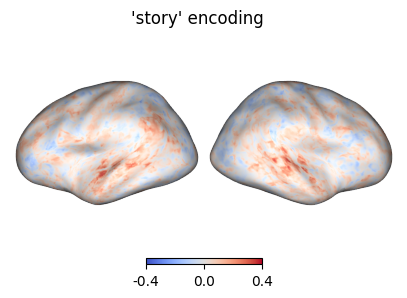

In [31]:
p = plot.get_surfplot(views='lateral', size=(400, 200), zoom=1.2)
p.add_layer(results[6]['scores'], cmap="coolwarm", color_range=(-.4, .4))
fig = p.build()
fig.suptitle("'story' encoding")
fig.show()

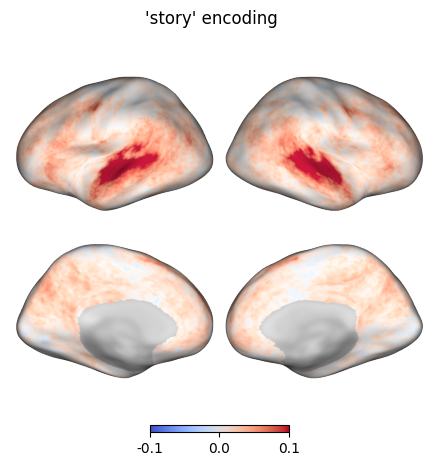

In [16]:
values = np.mean(story_scores, axis=0)
# values = black_scores[0]
# mx = max(np.abs(values.min()), values.max())

p = plot.get_surfplot()
p.add_layer(values, cmap="coolwarm", color_range=(-.1, .1))
fig = p.build()
fig.suptitle("'story' encoding")
fig.show()

In [28]:
from util.atlas import get_glasser, parcellate_voxels
parc_mask, id2label = get_glasser()

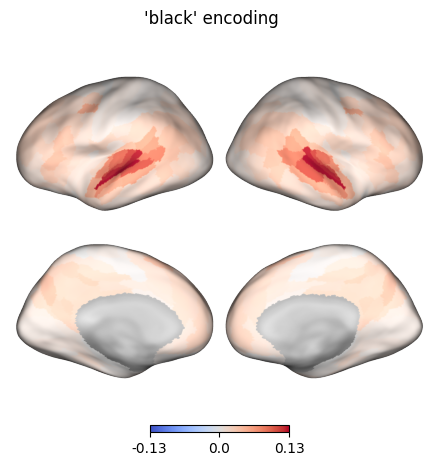

In [40]:
parcel_values = parcellate_voxels(values, parc_mask)
mx = max(np.abs(parcel_values.min()), parcel_values.max())

p = plot.get_surfplot()
p.add_layer(parcel_values, cmap="coolwarm", color_range=(-mx, mx))
fig = p.build()
fig.suptitle("'story' encoding")
fig.show()